In [41]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [2]:
load_dotenv()

True

In [45]:
class PostState(TypedDict):
    topic: str
    post: str
    status: Literal["approved", "needs_improvement"]
    feedback: str
    count_iterations: int

    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [13]:
class Status(BaseModel):
    status: Literal["approved", "needs_improvement"]
    feedback: str

In [61]:
model = ChatOpenAI(model='gpt-4o')
model_with_structured_output = model.with_structured_output(Status)

In [62]:
def generate_post(state: PostState):
    messages = [
        SystemMessage(content="You are a smart social media influencer."),
        HumanMessage(content=f"""
Write a short and original post on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use simple, day to day english syntax and grammar.
""")
    ]

    post = model.invoke(messages).content.strip()

    return {"post": post, "post_history": [post]}

In [72]:
def evaluate_post(state: PostState):
    messages = [
        SystemMessage(content="You are a strict but helpful social media content reviewer."),
        HumanMessage(content=f"""
Evaluate the following social media post based on the topic and rules below.

Topic: "{state['topic']}"
Post: "{state['post']}"

Your task is to:
1. Give a one-word evaluation: "approved" or "needs_improvement"
2. Provide a short, constructive feedback message (1–2 sentences)

Rejection Criteria:
- The post is written in a question-answer format
- The post contains gibberish or random text
- The post lacks clarity or does not make sense
- The post contains emojis
- The post contains "!"
- The post contains em dashes

Respond only in this format:
status: <approved or needs_improvement>
feedback: <short explanation>
""")
    ]

    response = model_with_structured_output.invoke(messages)
    return {"status": response.status, "feedback": response.feedback, "feedback_history": [response.feedback]}

In [73]:
def revise_post(state: PostState) -> dict:
    messages = [
        SystemMessage(content="You are a smart and helpful social media content writer, editor and reviewer."),
        HumanMessage(content=f"""
Revise the following post "{state['post']}" based on the topic "{state['topic']}" and feedback "{state['feedback']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use simple, day to day english syntax and grammar.

Give the improved post only.
""")
    ]

    revised_post = model.invoke(messages).content.strip()
    count_iterations = state["count_iterations"] + 1
    return {"revised_post": revised_post, "count_iterations": count_iterations, "post_history": [revised_post]}

In [74]:
def check_status(state: PostState):
    status = state["status"]
    count_iterations = state["count_iterations"]

    if status == "approved" or count_iterations == 5:
        return "approved"
    else:
        return "needs_improvement"

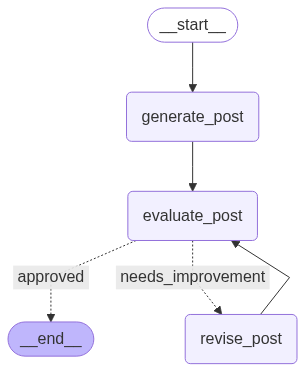

In [75]:
graph = StateGraph(PostState)

graph.add_node("generate_post", generate_post)
graph.add_node("evaluate_post", evaluate_post)
graph.add_node("revise_post", revise_post)

graph.add_edge(START, "generate_post")
graph.add_edge("generate_post", "evaluate_post")
graph.add_conditional_edges("evaluate_post", check_status,
                            {
                                "approved": END,
                                "needs_improvement": "revise_post",
                            })

graph.add_edge("revise_post", "evaluate_post")
workflow = graph.compile()
workflow

In [77]:
intial_state = {
    "topic": "AI in Pakistan",
    "count_iterations": 1,
}

result = workflow.invoke(intial_state)

In [82]:
result

{'topic': 'AI in Pakistan',
 'post': 'Pakistan is embracing the AI wave! From smart cities to healthcare innovation, the country is weaving tech into its fabric. Young minds and startups are leading the charge, crafting solutions that promise a brighter, data-driven future. 🌟#AIPakistan #Innovation',
 'status': 'needs_improvement',
 'feedback': 'Remove the emoji and exclamation marks for a more polished presentation while maintaining engagement with the topic.',
 'count_iterations': 5,
 'post_history': ['Pakistan is embracing the AI wave! From smart cities to healthcare innovation, the country is weaving tech into its fabric. Young minds and startups are leading the charge, crafting solutions that promise a brighter, data-driven future. 🌟#AIPakistan #Innovation',
  'Pakistan is embracing the AI wave. From smart cities to healthcare innovation, the country is integrating technology into its fabric. Young minds and startups are leading the charge, crafting solutions that promise a bright

In [81]:
result["post_history"][-1]

'Pakistan is embracing the AI wave. From smart cities to healthcare innovation, the country is integrating tech into its core. Young minds and startups are leading the charge, crafting solutions that promise a brighter, data-driven future. #AIPakistan #Innovation'